# Text Features

In [31]:
import torch
from PIL import Image
from transformers import AutoProcessor, CLIPModel, AutoModel,AutoImageProcessor
import torch.nn as nn
import requests
from io import BytesIO
import faiss
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

In [32]:
def cosine_similarity(vec1, vec2):
    # Compute the dot product of vec1 and vec2
    dot_product = np.dot(vec1, vec2)
    
    # Compute the L2 norm of vec1 and vec2
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    # Compute the cosine similarity
    similarity = dot_product / (norm_vec1 * norm_vec2)
    
    return similarity

In [63]:
def load_image(image_path):
    if image_path.startswith("http://") or image_path.startswith("https://"):
        return Image.open(requests.get(image_path, stream=True).raw)
    else:
        return Image.open(image_path)

In [35]:
product_names = [
    "Royal Salute 21 YO 70cl",
    "Aberfeldy 12 YO Sp",
    "Aberlour A Bunadh 70cl",
    "Absolut 100 100cl",
    "Absolut Citron 100cl",
    "Absolut Elyx 100cl",
    "Absolut Lime 100cl",
    "Absolut Mandrin 100cl",
    "Absolut Mango 100cl",
    "Absolut Pears 100cl",
    "Absolut Vodka Blue 100cl",
    "Absolut Vodka Grapefruit 100cl",
    "Bacardi Carta Blanca 100cl",
    "Bacardi Ocho",
    "Baileys Original 100 CL",
    "Baileys Salted Caramel 100cl",
    "Ballantine's 30 YO 70cl",
    "Beluga Celebration 100 CL",
    "Beluga Gold Line 1 L",
    "Ballantine's Finest Twin Pack Cary 2x100cl"
]

class_names=product_names
# Compute text features for class names
text_inputs = processor(text=class_names, return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    text_features = model.get_text_features(**text_inputs)

In [59]:
def predict(img_url):
    image1 = load_image(img_url)
    #image1=img_url
    with torch.no_grad():
        inputs1 = processor(images=image1, return_tensors="pt").to(device)
        image_features1 = model.get_image_features(**inputs1)
    cos_sim = nn.CosineSimilarity(dim=-1)
    similarity_scores = cos_sim(image_features1, text_features)
    similarity_scores=similarity_scores.tolist()
    # Get the index of the class with the highest similarity score
    merged_dict=dict(zip(product_names,similarity_scores))
    sorted_dict = dict(sorted(merged_dict.items(), key=lambda item: item[1],reverse=True))
    return sorted_dict

# Image Features

In [37]:
images = []
img_skus=[]
for root, dirs, files in os.walk(r"\Liquor images"):
    for file in files:
        if file.endswith('png'):
            images.append(root  + '/'+ file)
img_skus=images.copy()
for i in range(len(img_skus)):
    img_skus[i]=os.path.basename(img_skus[i])[:-4]

In [38]:
def extract_features_clip(image):
    with torch.no_grad():
        inputs1 = processor(images=image, return_tensors="pt").to(device)
        image_features = model.get_image_features(**inputs1)
    return image_features

total_image_features=[]
for image_path in images:
    img = Image.open(image_path).convert('RGB')
    clip_feature = extract_features_clip(img)
    total_image_features.append(clip_feature)

import pickle
filename='images.pkl'
with open(filename,'wb') as f:
    pickle.dump(total_image_features,f)

In [39]:
with open(filename,'rb') as f:
    features=pickle.load(f)

In [60]:
def image_similarity(url):
    source=url
    image = load_image(source)
    #image=url
    with torch.no_grad():
        inputs1 = processor(images=image, return_tensors="pt").to(device)
        image_features = model.get_image_features(**inputs1)
    similarity_scores = [cosine_similarity(image_features, i[0]) for i in features]
    merged_dict=dict(zip(img_skus,similarity_scores))
    sorted_dict = dict(sorted(merged_dict.items(), key=lambda item: item[1],reverse=True))
    return sorted_dict

In [61]:
def image_search(url):
    text_similarity=predict(url)
    img_similarity=image_similarity(url)
    #text_similarity=predict(img)
    #img_similarity=image_similarity(img)
    result={}
    for k,v in text_similarity.items():
        result[k]=0.5*text_similarity[k]*3+0.5*img_similarity[k]
    top_5_keys = sorted(result, key=result.get, reverse=True)[:5]
    return result

import streamlit as st
st.header('Image Search App')

uploaded_file = st.file_uploader("Choose an image...", type=['png','jpg','jpeg'])
picture_width = st.sidebar.slider('Picture Width', min_value=100, max_value=500)
if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.subheader('Input', divider='rainbow')
    st.image(image, caption='Uploaded Image', width=picture_width)

        # Call your function with the uploaded image
    results = image_search(image)
    
    st.subheader('Results', divider='rainbow')
        # Display the results
    for product in results:
        product_image_path = os.path.join('C:\\suresh\\AdaniOne Duty Free Liquor images', f'{product}.png')
        product_image = Image.open(product_image_path)
        st.image(product_image, caption=product, width=picture_width)

In [96]:
abc = image_search(r"download (5).jpg")

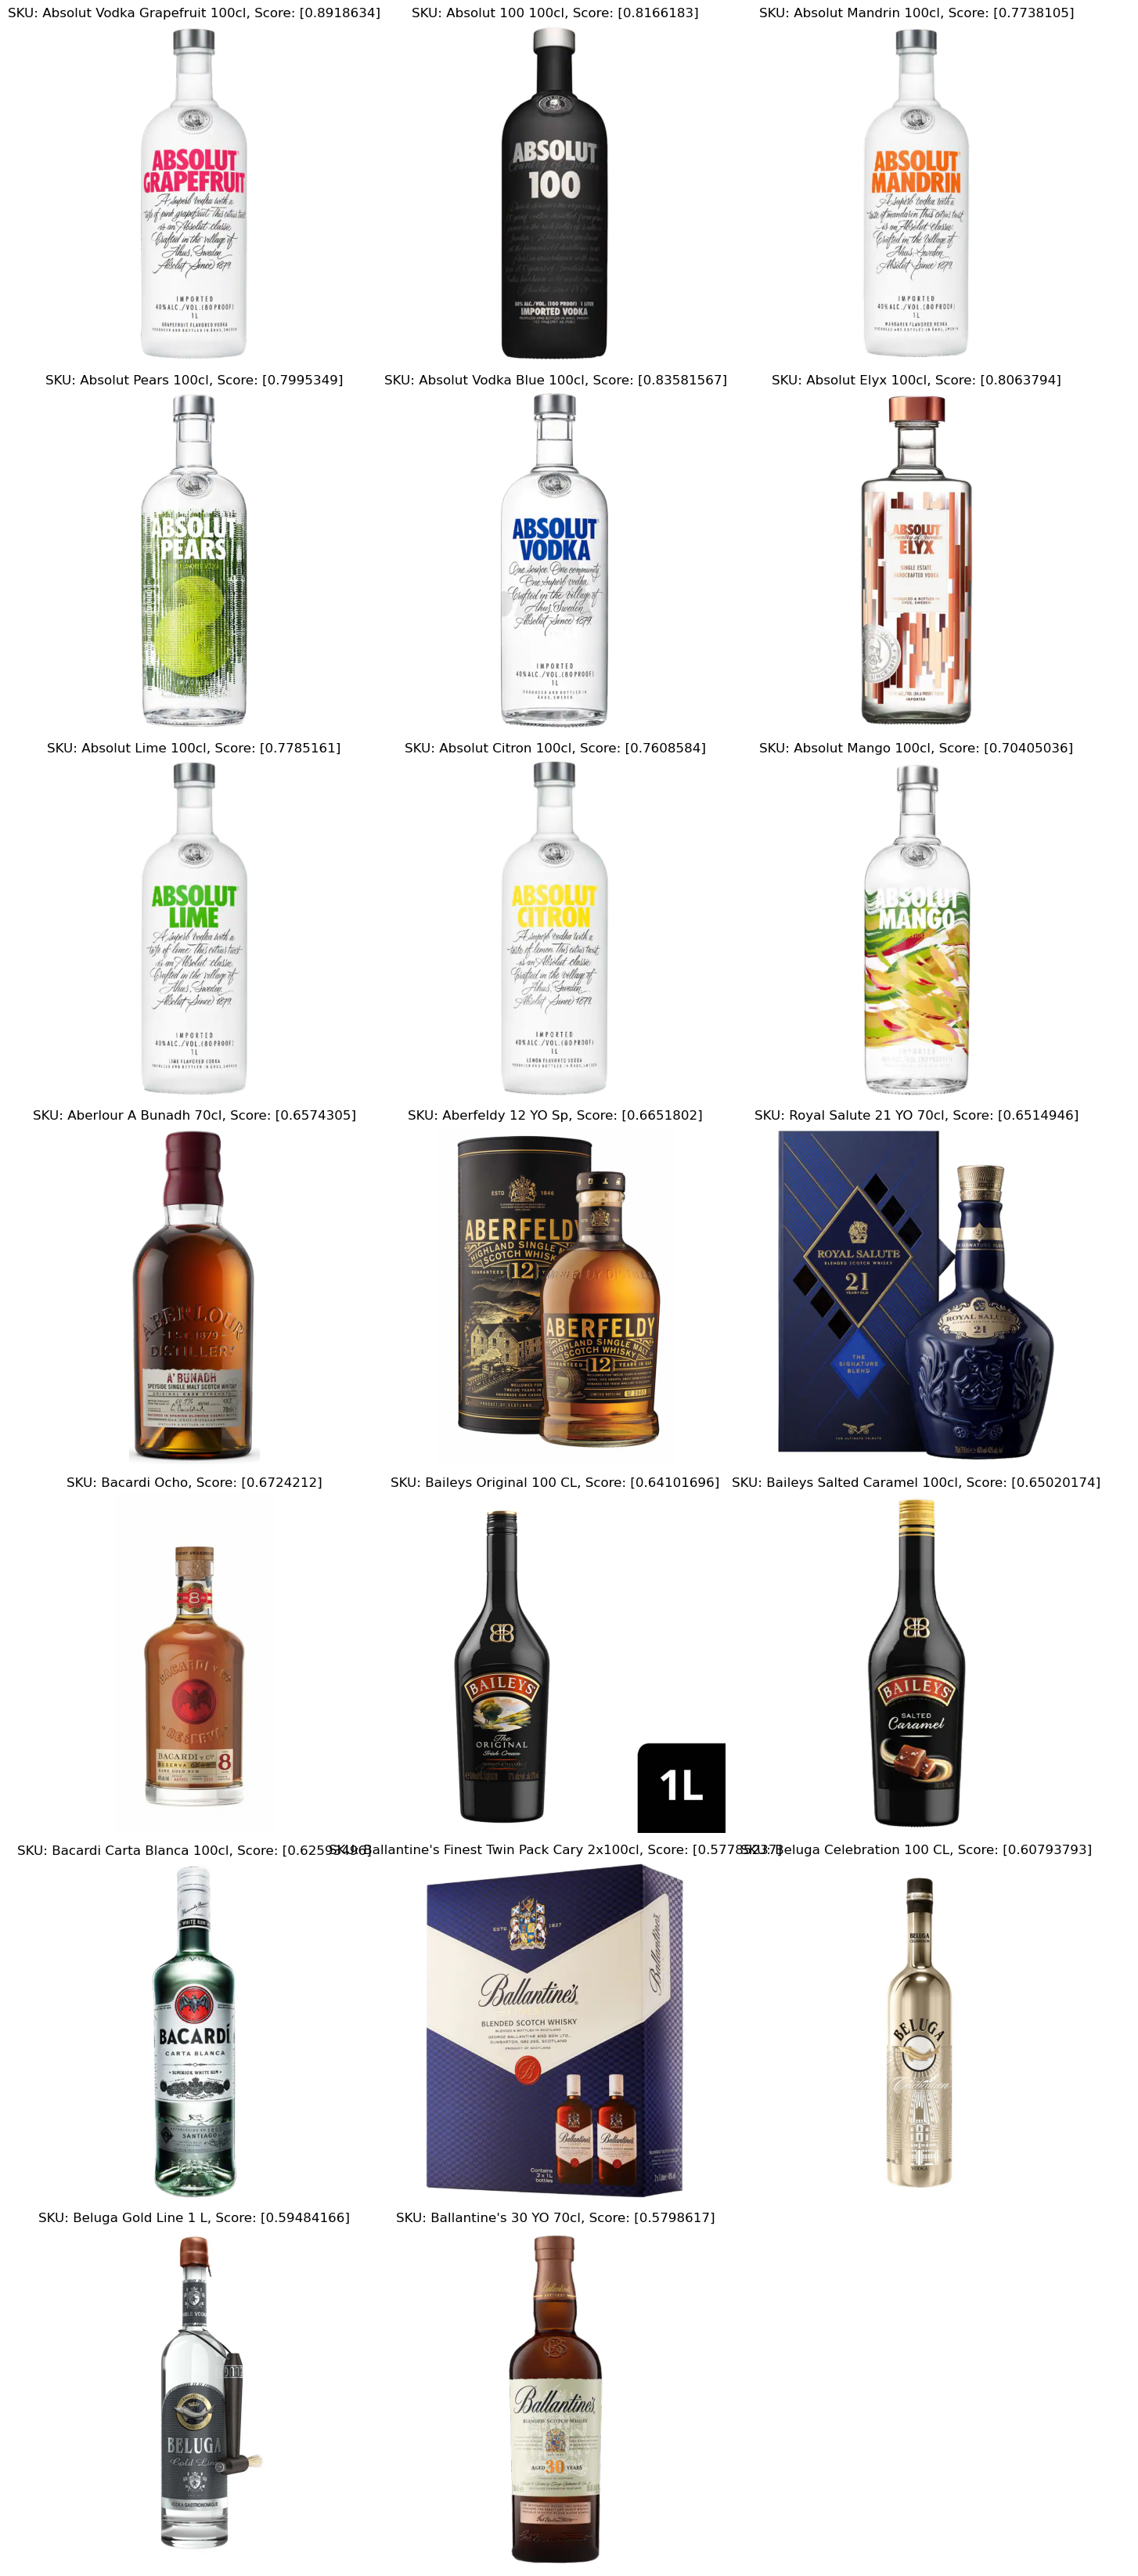

In [97]:
num_images = len(abc)
fig, axes = plt.subplots(nrows=num_images//3 + (1 if num_images % 3 else 0), ncols=3, figsize=(15, 5 * num_images//3))
axes = axes.ravel()  # Flatten the axes array

for idx, (i, k) in enumerate(abc.items()):
    product_image_path = os.path.join('C:\\suresh\\AdaniOne Duty Free Liquor images', f'{i}.png')
    product_image = Image.open(product_image_path)
    axes[idx].imshow(np.array(product_image))
    axes[idx].set_title(f"SKU: {i}, Score: {k}")
    axes[idx].axis('off')

# If the number of images is not a multiple of 3, hide the remaining subplots
for j in range(num_images, 3 * (num_images//3 + (1 if num_images % 3 else 0))):
    axes[j].axis('off')

plt.tight_layout()
plt.show()